In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# import the necessary packages
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

class SmallerVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# CONV => RELU => POOL
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(3, 3)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# (CONV => RELU) * 2 => POOL
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))

		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(1024))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

Using TensorFlow backend.


In [0]:
import matplotlib
# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from imutils import paths
import numpy as np
import argparse
import random
import pickle
import cv2
import os


In [0]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
IMAGE_DIMS = (96, 96, 3)

In [9]:


# initialize the data and labels
data = []
labels = []

# grab the image paths and randomly shuffle them
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/dataset')))
random.seed(42)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
	# load the image, pre-process it, and store it in the data list
	image = cv2.imread(imagePath)
	image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
	image = img_to_array(image)
	data.append(image)
 
	# extract the class label from the image path and update the
	# labels list
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)
print("[INFO] data matrix: {:.2f}MB".format(
	data.nbytes / (1024 * 1000.0)))

# binarize the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.2, random_state=42)

# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

[INFO] loading images...
[INFO] data matrix: 252.07MB


In [0]:
with open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/trainX.pkl', "wb") as f:
    pickle.dump(trainX, f)
with open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/testX.pkl', "wb") as f:
    pickle.dump(testX, f)
with open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/trainY.pkl', "wb") as f:
    pickle.dump(trainY, f)
    
with open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/testY.pkl', "wb") as f:
    pickle.dump(testY, f)
    
with open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/lb.pkl', "wb") as f:
    pickle.dump(lb, f)

In [11]:
# initialize the model
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=IMAGE_DIMS[1], height=IMAGE_DIMS[0],
	depth=IMAGE_DIMS[2], classes=len(lb.classes_))
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1)

[INFO] training network...
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
29/29 [==============================] - 8s 280ms/step - loss: 1.4523 - acc: 0.6024 - val_loss: 2.1185 - val_acc: 0.6581
Epoch 2/100
29/29 [==============================] - 3s 99ms/step - loss: 0.7434 - acc: 0.7741 - val_loss: 1.5717 - val_acc: 0.6880
Epoch 3/100
29/29 [==============================] - 3s 104ms/step - loss: 0.6817 - acc: 0.7881 - val_loss: 1.0769 - val_acc: 0.7650
Epoch 4/100
29/29 [==============================] - 3s 106ms/step - loss: 0.6479 - acc: 0.8065 - val_loss: 0.9181 - val_acc: 0.7863
Epoch 5/100
29/29 [==============================] - 3s 104ms/step - loss: 0.6098 - acc: 0.8062 - val_loss: 0.6687 - val_acc: 0.8675
Epoch 6/100
29/29 [==============================] - 3s 103ms/step - loss: 0.5524 - acc: 0.8323 - val_loss: 0.9086 - val_acc: 0.7650
Epoch 7/100
29/29 [==============================] - 3s 106ms/step - loss: 0.5080 - acc: 0.8350 - val_loss: 0.9933 - val_acc: 0.

In [13]:
# save the model to disk
print("[INFO] serializing network...")
model.save('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/pokedex.model')

[INFO] serializing network...


In [24]:
import matplotlib.pyplot as plt
from keras.models import load_model
import imutils

# load the trained convolutional neural network and the label
# binarizer
print("[INFO] loading network...")
model = load_model('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/pokedex.model')
lb = pickle.loads(open('/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/lb.pkl', "rb").read())




def test(image):
  output = image.copy()

  # pre-process the image for classification
  image = cv2.resize(image, (96, 96))
  image = image.astype("float") / 255.0
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)



  # classify the input image
  print("[INFO] classifying image...")
  proba = model.predict(image)[0]
  idx = np.argmax(proba)
  label = lb.classes_[idx]

  # we'll mark our prediction as "correct" of the input image filename
  # contains the predicted label text (obviously this makes the
  # assumption that you have named your testing image files this way)
  filename = image_path[image_path.rfind(os.path.sep) + 1:]
  correct = "correct" if filename.rfind(label) != -1 else "incorrect"

  print(filename)
  # build the label and draw the label on the image
  label = "{}: {:.2f}% ({})".format(label, proba[idx] * 100, correct)
  output = imutils.resize(output, width=400)
  cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
    0.7, (0, 255, 0), 2)

  # show the output image
  print("[INFO] {}".format(label))

  plt.imshow(output)

[INFO] loading network...


[INFO] classifying image...
charmander_counter.png
[INFO] charmander: 99.80% (correct)


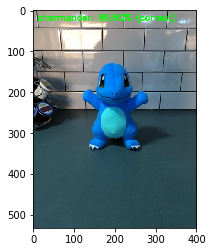

In [25]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/charmander_counter.png'
image = cv2.imread(image_path)

test(image)

[INFO] classifying image...
bulbasaur_plush.png
[INFO] bulbasaur: 97.76% (correct)


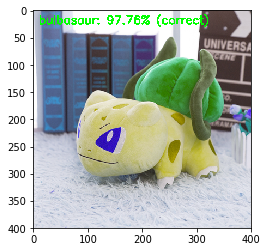

In [26]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/bulbasaur_plush.png'
image = cv2.imread(image_path)

test(image)

[INFO] classifying image...
mewtwo_toy.png
[INFO] mewtwo: 99.93% (correct)


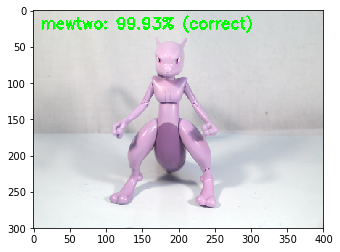

In [27]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/mewtwo_toy.png'
image = cv2.imread(image_path)

test(image)

[INFO] classifying image...
pikachu_toy.png
[INFO] pikachu: 99.95% (correct)


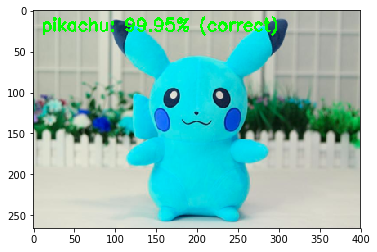

In [28]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/pikachu_toy.png'
image = cv2.imread(image_path)

test(image)

[INFO] classifying image...
squirtle_plush.png
[INFO] squirtle: 96.91% (correct)


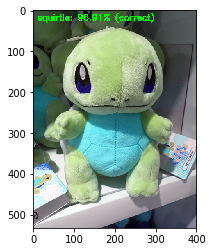

In [29]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/squirtle_plush.png'
image = cv2.imread(image_path)

test(image)

[INFO] classifying image...
charmander_hidden.png
[INFO] charmander: 78.14% (correct)


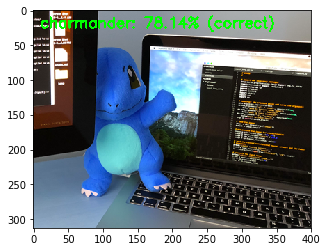

In [30]:
# load the image
image_path = '/content/gdrive/My Drive/app/ASimpleConvolutionalNeuralNetwork(CNN)/examples/charmander_hidden.png'
image = cv2.imread(image_path)

test(image)